## <font color=FF4455>Clustering for OSA</font>


### Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from itertools import combinations

### Load Data

In [2]:
def read_data(xlsx_data):
    """
    Reads xlsx file, separates features from variables, and normalizes the data.
    """
    df = pd.read_excel(xlsx_data)
    # Define feature matrix (X) and target variable (y)
    if 'Patient' in df.columns:
        X = df.drop('Patient', axis=1)
    return X

In [3]:
X = read_data('../datasets/Clinical_data.xlsx')

# Models

### Useful functions

Fitting and evaluating models

In [4]:
def cluster_compactness(X, labels):
    unique_labels = np.unique(labels)
    total_comp = 0
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        center = np.mean(cluster_points, axis=0)
        dists = np.linalg.norm(cluster_points - center, axis=1)
        total_comp += np.mean(dists)
    return total_comp / len(unique_labels)

In [5]:
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else None
    db = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else None
    cmpt = cluster_compactness(X, labels)
    return {'Silhouette': sil, 'Davies-Bouldin': db, 'cmpt': cmpt}

In [6]:
def fit_and_evaluate_clustering(model, X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model.fit(X)
    labels = model.labels_
    # Compute cluster centers manually for AgglomerativeClustering
    if hasattr(model, "cluster_centers_"):
        centers = model.cluster_centers_
        centers = scaler.inverse_transform(centers)
    else:
        # Calculate centroids manually
        centers = np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])
    df_centers = pd.DataFrame(data=centers)
    metrics = evaluate_clustering(X, labels)  
    return labels, df_centers, metrics

Elbow method for Kmeans clustering

In [7]:
def elbow_method(X, max_clusters=10):
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method')
    plt.show()

Plotting and visualization functions

In [8]:
def visualize_clusters(X, labels, centers, x_label, y_label):
    centers_arr = centers.values if hasattr(centers, 'values') else centers
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis')
    plt.scatter(centers_arr[:, 0], centers_arr[:, 1], c='black', s=100, alpha=0.5)
    plt.title(f'{x_label} vs {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

def visualize_all_clusters(X, model_name, labels, centers):
    feature_names = X.columns.drop('Gender')
    combos = list(combinations(feature_names, 2))
    rows = int(np.ceil(len(combos) / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(10, 5*rows))
    for ax, combo in zip(axes.ravel(), combos):
        X_combo = X[list(combo)].values
        plt.sca(ax)
        visualize_clusters(X_combo, labels, centers, combo[0], combo[1])
    plt.suptitle(f'Clusters using {model_name}')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_dendrogram_with_height(X):
    """
    Plot dendrogram and add a horizontal line to help determine optimal clusters
    """
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create linkage matrix
    linkage_matrix = linkage(X_scaled, method='ward')
    
    plt.figure(figsize=(10, 7))
    
    # Plot dendrogram
    dendrogram(linkage_matrix)
    
    # Add horizontal line to help identify clusters
    plt.axhline(y=5, color='r', linestyle='--') # Adjust y value based on desired height cut
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

In [10]:
def plot_metrics(metrics_dict):
    """
    Plots the metrics for different models.
    
    Parameters:
    metrics_dict (dict): A dictionary where keys are model names and values are dictionaries of metrics.
    """
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[models[0]].keys())
    
    for metric in metrics:
        values = [metrics_dict[model][metric] for model in models]
        plt.figure(figsize=(10, 5))
        plt.bar(models, values)
        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.title(f'{metric} for different models')
        plt.show()

### Kmeans

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


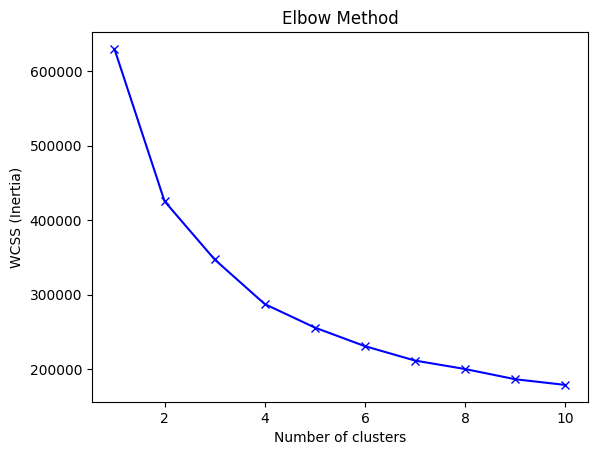

In [11]:
# Use the elbow method to determine the best number of clusters
elbow_method(X, max_clusters=10)

In [12]:
best_k = 5
kmeans_model = KMeans(n_clusters=best_k, random_state=42)

# Fit the model and evaluate
labels, df_centers, kmeans_metrics = fit_and_evaluate_clustering(kmeans_model, X)

In [13]:
kmeans_metrics

{'Silhouette': np.float64(0.23460692254889612),
 'Davies-Bouldin': np.float64(1.4512004360811446),
 'cmpt': np.float64(1.7958243901004594)}

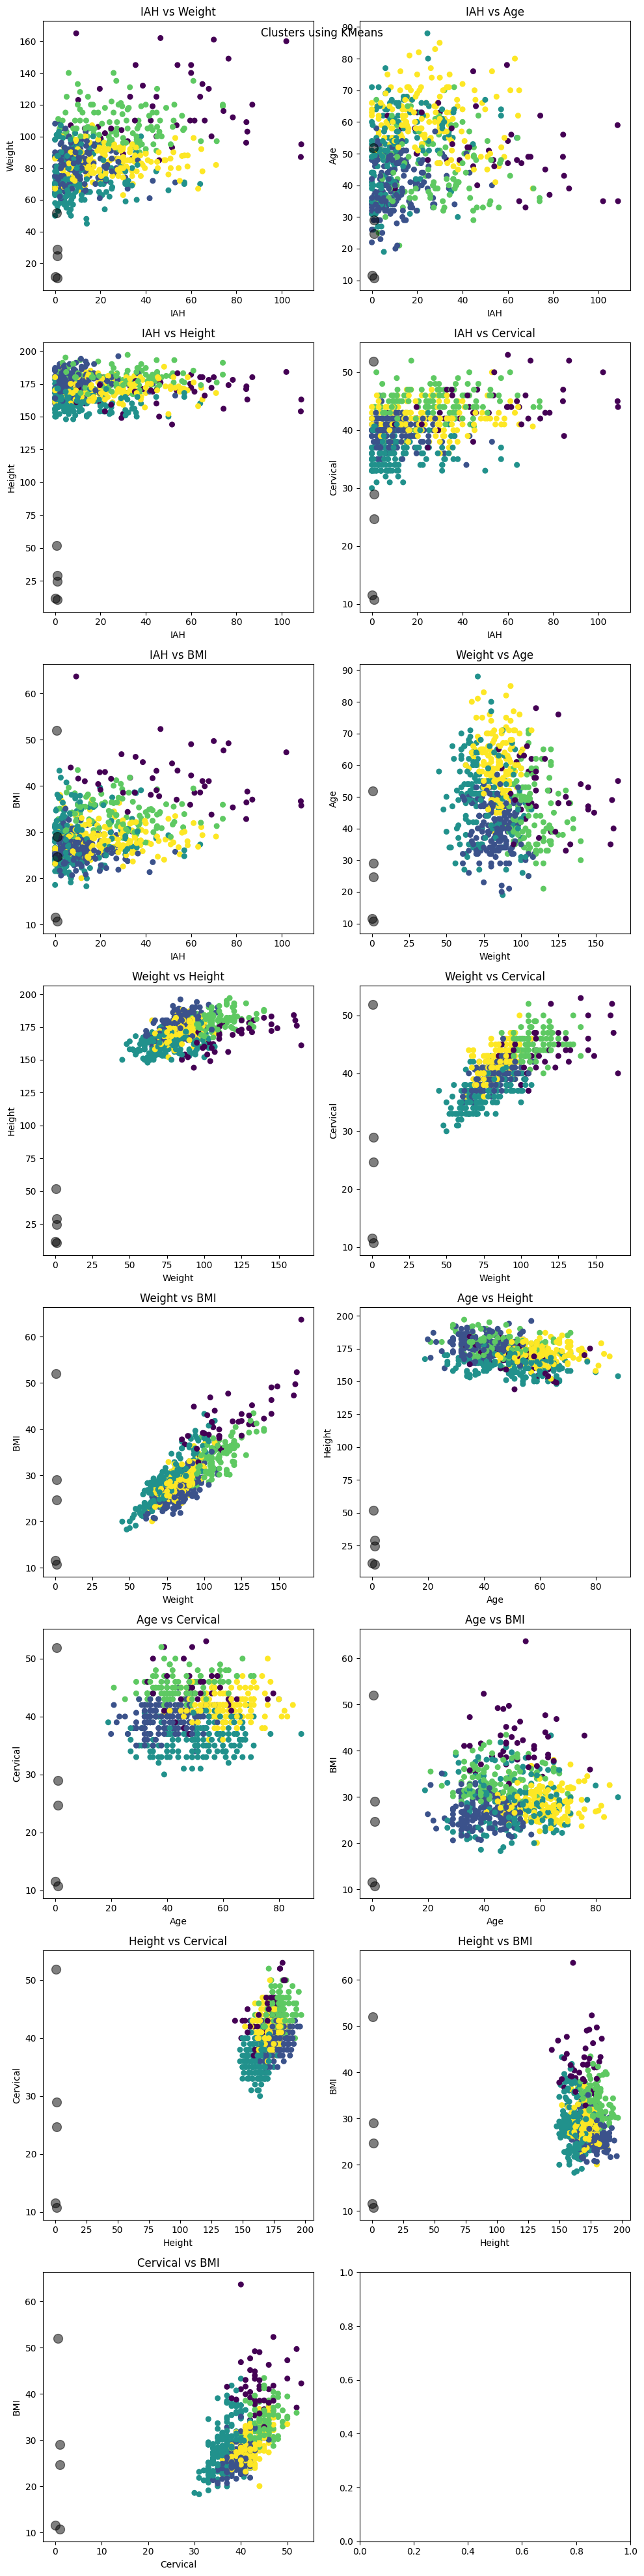

In [14]:
visualize_all_clusters(X, 'KMeans', labels, df_centers)

### Hierarchical Clustering

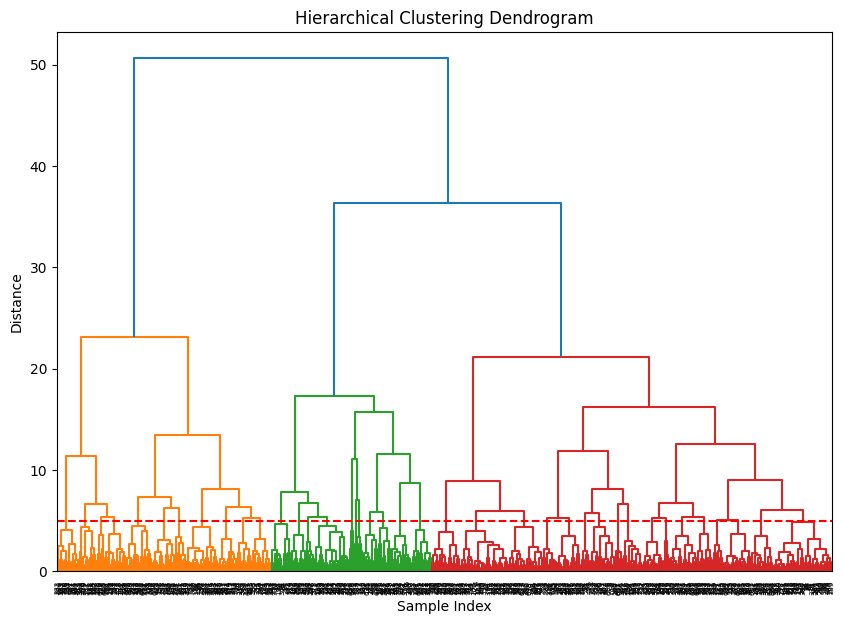

In [15]:
plot_dendrogram_with_height(X)

Agglomerative Clustering Metrics: {'Silhouette': np.float64(0.19132183652950008), 'Davies-Bouldin': np.float64(1.4105326584723534), 'cmpt': np.float64(1.6257052461068118)}


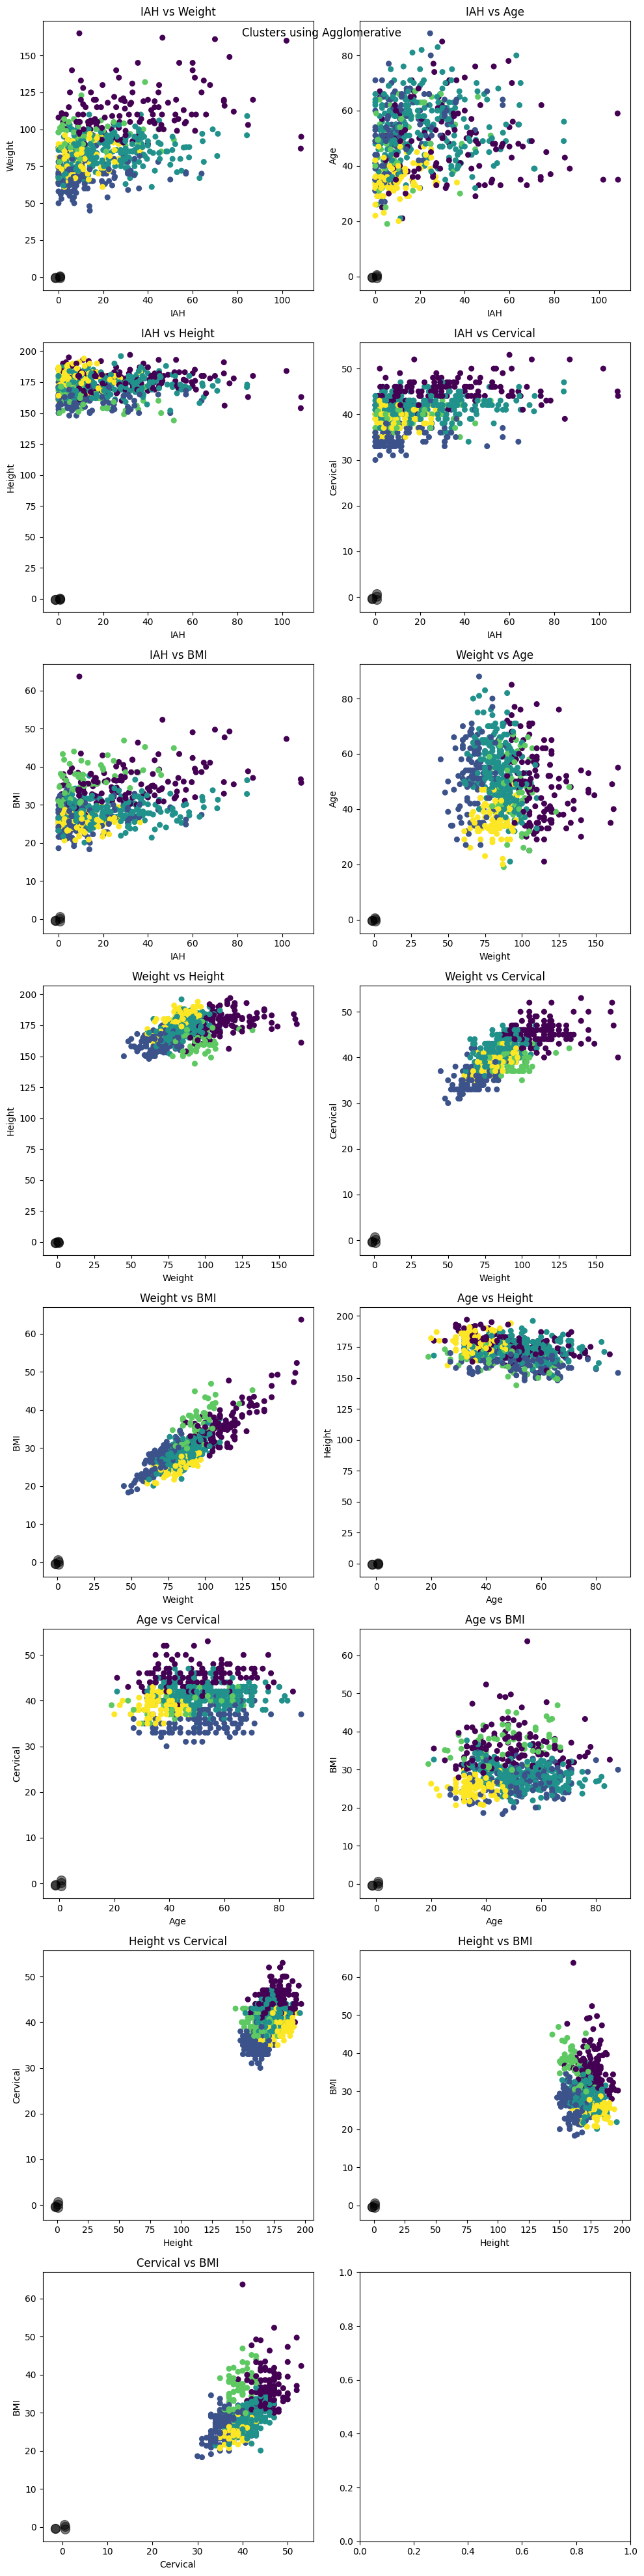

In [16]:
# Fit the Agglomerative Clustering model and evaluate
agg_model = AgglomerativeClustering(n_clusters=5)
labels_agg, df_centers_agg, agg_metrics = fit_and_evaluate_clustering(agg_model, X)

# Print metrics
print("Agglomerative Clustering Metrics:", agg_metrics)

# Visualize clusters
visualize_all_clusters(X, 'Agglomerative', labels_agg, df_centers_agg)

DBSCAN Metrics: {'Silhouette': np.float64(-0.25165932300103994), 'Davies-Bouldin': np.float64(2.2223468455290516), 'cmpt': np.float64(1.1827536334696518)}


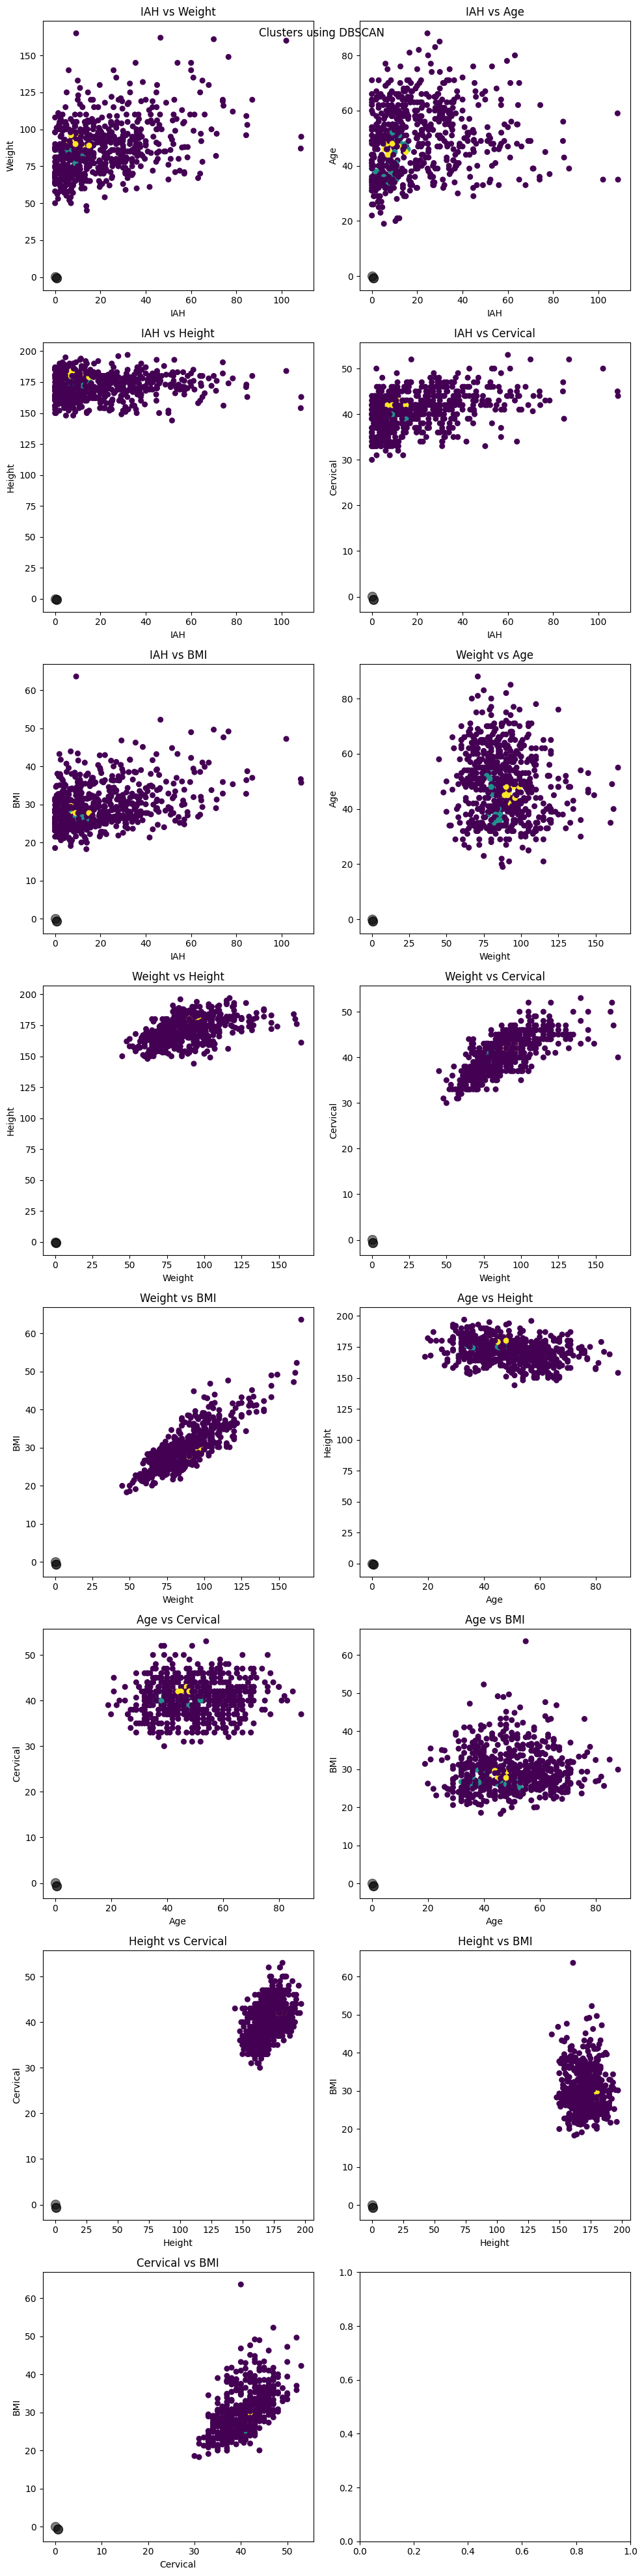

In [17]:
# Fit the DBSCAN model and evaluate
dbscan_model = DBSCAN()
labels_dbscan, df_centers_dbscan, dbscan_metrics = fit_and_evaluate_clustering(dbscan_model, X)

# Print metrics
print("DBSCAN Metrics:", dbscan_metrics)

# Visualize clusters
visualize_all_clusters(X, 'DBSCAN', labels_dbscan, df_centers_dbscan)

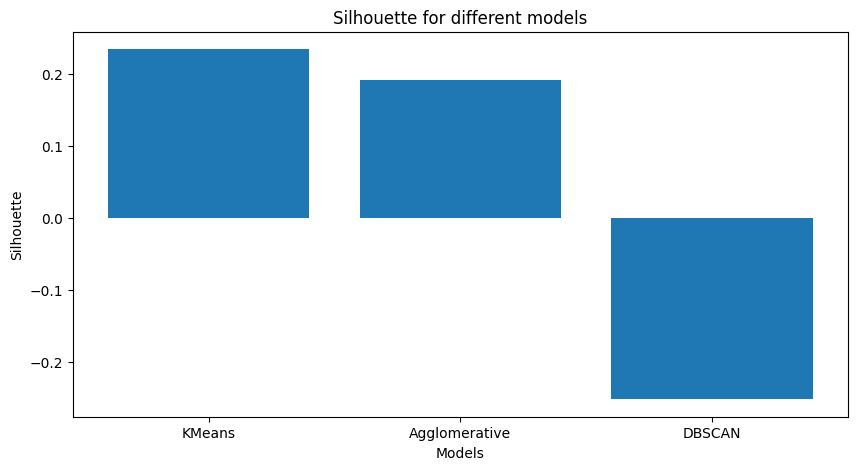

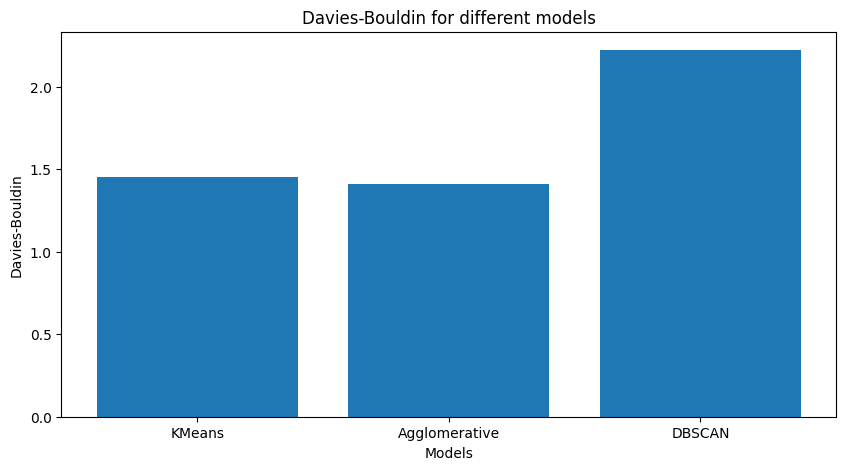

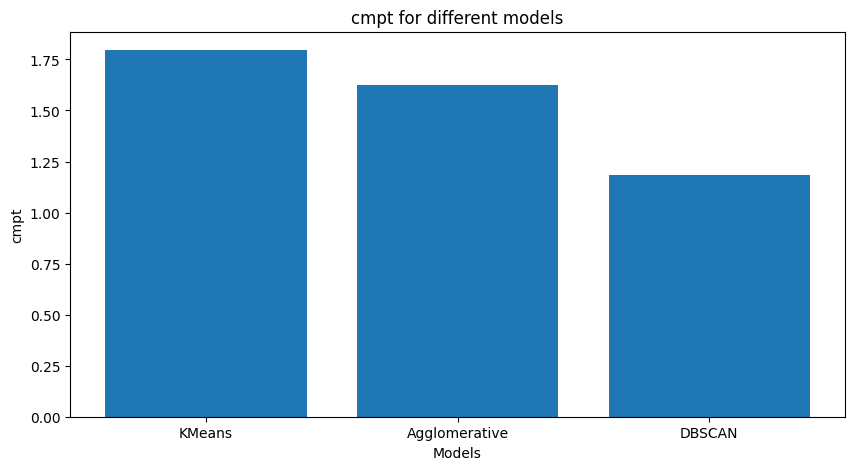

In [21]:
# Combine metrics into one dictionary
all_metrics = {
    'KMeans': kmeans_metrics,
    'Agglomerative': agg_metrics,
    'DBSCAN': dbscan_metrics
}

# Plot the metrics
plot_metrics(all_metrics)

In [22]:
all_metrics

{'KMeans': {'Silhouette': np.float64(0.23460692254889612),
  'Davies-Bouldin': np.float64(1.4512004360811446),
  'cmpt': np.float64(1.7958243901004594)},
 'Agglomerative': {'Silhouette': np.float64(0.19132183652950008),
  'Davies-Bouldin': np.float64(1.4105326584723534),
  'cmpt': np.float64(1.6257052461068118)},
 'DBSCAN': {'Silhouette': np.float64(-0.25165932300103994),
  'Davies-Bouldin': np.float64(2.2223468455290516),
  'cmpt': np.float64(1.1827536334696518)}}